# Data Analysis and Visualization

Through data analysis and visualization, we can attempt to answer questions about our data and about the metric that we have created

### Loading in the Data

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
games = pd.read_csv('../games.csv')
playerData = pd.read_csv('../players.csv')
tackleData = pd.read_csv('../tackles.csv')
plays = pd.read_csv("../plays.csv")

In [4]:
totaltracking = []

for i in range(9):
    string = '../tracking_week_' + str(i + 1) + 'data.csv'
    track = pd.read_csv(string)
    totaltracking.append(track)
    
trackingdata = pd.concat(totaltracking, axis=0, ignore_index=True)

In [84]:
#Concrete Stats for each tackle

ball_carrier = pd.DataFrame(plays.loc[:, ['playId', 'ballCarrierId', 'gameId', 'down', 'yardsToGo', 'playResult']])
ball_carrier['timeLeft'] = ((4 - plays['quarter']) * 15 + plays['gameClock'].str[:-3].astype(int)).astype(str) + plays['gameClock'].str[-3:]
ball_carrier['scoreDif'] = abs(plays['preSnapHomeScore'].sub(plays['preSnapVisitorScore']))
ball_carrier['endZoneDistance'] = 110 - plays['absoluteYardlineNumber'] - plays['playResult']
ball_carrier['yardsto1st'] = plays['yardsToGo'] - plays['playResult']
ball_carrier['defensiveTeam'] = plays['defensiveTeam']
tackler = pd.DataFrame(tackleData.loc[:, ['playId', 'nflId', 'gameId']])
name = pd.DataFrame(playerData.loc[:, ['nflId', 'displayName']])

tackle_stats = pd.merge(ball_carrier, tackler, on=('playId', 'gameId'))
tackle_stats = pd.merge(tackle_stats, name, on='nflId')

tackle_stats

,playId,ballCarrierId,gameId,down,yardsToGo,playResult,timeLeft,scoreDif,endZoneDistance,yardsto1st,defensiveTeam,nflId,displayName
0,3537,48723,2022100908,1,10,9,7:52,14,32,1,TB,43306,Keanu Neal
1,84,47853,2022110609,2,10,5,59:50,0,22,5,TB,43306,Keanu Neal
2,1016,53555,2022102301,1,10,9,41:29,0,41,1,TB,43306,Keanu Neal
3,879,52460,2022110609,3,1,2,45:58,3,16,-1,TB,43306,Keanu Neal
4,97,46155,2022102700,1,10,5,59:18,0,52,5,TB,43306,Keanu Neal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17421,3790,54556,2022101607,4,1,2,5:10,8,11,-1,PIT,52904,Elijah Riley
17422,1945,53549,2022100905,2,10,-1,26:45,16,82,11,DET,55030,Demetrius Taylor
17423,3201,47807,2022110604,2,10,3,7:24,4,24,7,JAX,48508,Andrew Wingard
17424,779,53454,2022103000,2,2,2,47:42,7,39,0,DEN,48308,Jonathan Kongbo


In [85]:
#Distance between players for each tackle
outcomes = ['pass_outcome_caught', 'handoff', 'run']
tacklesDist = pd.DataFrame(tackle_stats.loc[:, ['gameId', 'playId', 'nflId','ballCarrierId']])

#Defense x and y values
defenseLocation = pd.merge(trackingdata, tacklesDist, on=('gameId', 'playId', 'nflId'))
defenseDistance = defenseLocation[defenseLocation['event'].isin(outcomes)]

#Offense x and y values
offenseLocation = pd.merge(trackingdata, tacklesDist, left_on=('gameId', 'playId', 'nflId'), right_on=('gameId', 'playId', 'ballCarrierId'))
offenseDistance = offenseLocation[offenseLocation['event'].isin(outcomes)]

#Finding Euclidean Distance
def calculate_distance(row):
    return np.sqrt((row['x_x'] - row['x_y'])**2 + (row['y_x'] - row['y_y'])**2)

#Combining them
totaldistance = pd.merge(defenseDistance, offenseDistance, on=('gameId', 'playId'))
totaldistance['distanceBtPlayers'] = totaldistance.apply(calculate_distance, axis=1)
totaldistance = pd.DataFrame(totaldistance.loc[:, ['gameId','playId','nflId','x_x', 'y_x', 'x_y', 'y_y', 'event_y', 'ballCarrierId_y', 'distanceBtPlayers']])

In [86]:
#Final Clutch Stats Dataframe
newStats = pd.merge(tackle_stats, totaldistance[['gameId','playId','nflId','distanceBtPlayers']], on=('gameId', 'playId','nflId'))
newStats = newStats.drop_duplicates()
newStats = newStats.drop(['ballCarrierId', 'nflId', 'yardsToGo'], axis=1)
tackle_stats = newStats.reset_index(drop=True)
tackle_stats.head()


,playId,gameId,down,playResult,timeLeft,scoreDif,endZoneDistance,yardsto1st,defensiveTeam,displayName,distanceBtPlayers
0,3537,2022100908,1,9,7:52,14,32,1,TB,Keanu Neal,5.929798
1,84,2022110609,2,5,59:50,0,22,5,TB,Keanu Neal,10.935890
2,1016,2022102301,1,9,41:29,0,41,1,TB,Keanu Neal,18.493312
3,879,2022110609,3,2,45:58,3,16,-1,TB,Keanu Neal,4.460605
4,97,2022102700,1,5,59:18,0,52,5,TB,Keanu Neal,7.735069


In [87]:
tackle_stats['timeLeft'] = (tackle_stats['timeLeft'].str[:-3] + "." + (((tackle_stats['timeLeft'].str[-2:]).astype(int)*100/60).astype(str)).str[:1]).astype(float)
tackle_stats.head()

,playId,gameId,down,playResult,timeLeft,scoreDif,endZoneDistance,yardsto1st,defensiveTeam,displayName,distanceBtPlayers
0,3537,2022100908,1,9,7.8,14,32,1,TB,Keanu Neal,5.929798
1,84,2022110609,2,5,59.8,0,22,5,TB,Keanu Neal,10.935890
2,1016,2022102301,1,9,41.4,0,41,1,TB,Keanu Neal,18.493312
3,879,2022110609,3,2,45.9,3,16,-1,TB,Keanu Neal,4.460605
4,97,2022102700,1,5,59.3,0,52,5,TB,Keanu Neal,7.735069


In [92]:
# Add clutch stat to dataframe

tackle_stats['clutchness'] = 0
tackle_stats['clutchness'] += tackle_stats['down'] #Max = 4 Min = 1, 1 point for each down
tackle_stats['clutchness'] += tackle_stats.apply(lambda row: (np.log(abs(row['playResult']) + 2) * 4) if row['playResult'] <= 0 else 0, axis=1) #log scale for yards lost
tackle_stats['clutchness'] += tackle_stats.apply(lambda row: (15 - row['timeLeft'])/2 if row['timeLeft'] <= 15 and row['timeLeft'] > 0 else 0, axis=1) #up to 7.5 points, scales as closer to end game
tackle_stats['clutchness'] += tackle_stats.apply(lambda row: 10 if row['timeLeft'] < 0 else 0, axis=1) #10 points if OT
tackle_stats['clutchness'] += tackle_stats.apply(lambda row: (15 - row['scoreDif'])**2/30 if row['scoreDif'] <= 14 and row['timeLeft'] <= 30 else 0, axis=1) #up to 7.5 points after the 2nd half starts, scales as closer
tackle_stats['clutchness'] += tackle_stats.apply(lambda row: (50 - row['endZoneDistance'])**2/150 if row['endZoneDistance'] <= 50 and row['endZoneDistance'] >= 0 else 0, axis=1) #up to around 17 points, scales closer to end zone
tackle_stats['clutchness'] += tackle_stats.apply(lambda row: (6 - row['yardsto1st'])**2/5 if row['yardsto1st'] <= 5 and row['yardsto1st'] > 0 and (row['down'] != 1 or row['down'] != 2) else 0, axis=1) #up to 5 points and only for 3/4th down
tackle_stats['clutchness'] += tackle_stats['distanceBtPlayers']/10 #more points as you get further, max around 4 pts
tackle_stats['clutchness'] *= 4
tackle_stats

,playId,gameId,down,playResult,timeLeft,scoreDif,endZoneDistance,yardsto1st,defensiveTeam,displayName,distanceBtPlayers,clutchness
0,3537,2022100908,1,9,7.8,14,32,1,TB,Keanu Neal,5.929798,49.545252
1,84,2022110609,2,5,59.8,0,22,5,TB,Keanu Neal,10.935890,34.081023
2,1016,2022102301,1,9,41.4,0,41,1,TB,Keanu Neal,18.493312,33.557325
3,879,2022110609,3,2,45.9,3,16,-1,TB,Keanu Neal,4.460605,44.610909
4,97,2022102700,1,5,59.3,0,52,5,TB,Keanu Neal,7.735069,7.894028
...,...,...,...,...,...,...,...,...,...,...,...,...
17488,3790,2022101607,4,2,5.1,8,11,-1,PIT,Elijah Riley,1.938066,83.668560
17489,1945,2022100905,2,-1,26.7,16,82,11,DET,Demetrius Taylor,5.761467,27.882383
17490,3201,2022110604,2,3,7.4,4,24,7,JAX,Andrew Wingard,3.268272,58.667309
17491,779,2022103000,2,2,47.7,7,39,0,DEN,Jonathan Kongbo,8.165323,14.492796


In [95]:
maxs = tackle_stats['clutchness'].max()
print(maxs)
print(tackle_stats[tackle_stats['clutchness'] == 150.03807768158302])

150.03807768158302
      playId      gameId  down  playResult  timeLeft  scoreDif  \
7202    4519  2022091811     2         -61     -11.8         0   

      endZoneDistance  yardsto1st defensiveTeam     displayName  \
7202              100          71           ARI  Isaiah Simmons   

      distanceBtPlayers  clutchness  
7202          14.369805  150.038078  


(array([4918., 4060., 3512., 2341., 1389.,  713.,  355.,  125.,   56.,
          24.]),
 array([  4.01264911,  18.61519197,  33.21773482,  47.82027768,
         62.42282054,  77.0253634 ,  91.62790625, 106.23044911,
        120.83299197, 135.43553482, 150.03807768]),
 <BarContainer object of 10 artists>)

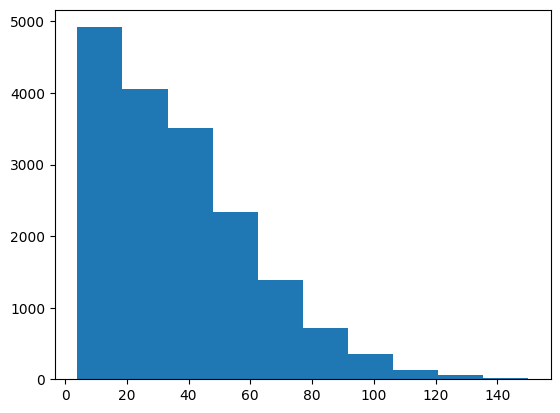

In [94]:
plt.hist(tackle_stats['clutchness'])

In [98]:
# Create new dataframe that contains the averages of the tackle stats
# for each unique player in displayName_x

individual_tackling = tackle_stats.groupby('displayName')[['down', 'scoreDif', 'yardsto1st', 'endZoneDistance', 'playResult', 'clutchness']].mean().reset_index()
individual_tackling['team'] = tackle_stats.groupby('displayName')['defensiveTeam'].first().reset_index()['defensiveTeam']
individual_tackling = individual_tackling.round({'down': 2, 'scoreDif': 2, 'yardsto1st': 2, 'endZoneDistance': 2,'playResult': 2, 'clutchness': 2})

individual_tackling

,displayName,down,scoreDif,yardsto1st,endZoneDistance,playResult,clutchness,team
0,A'Shawn Robinson,1.46,5.69,4.54,47.00,3.64,29.36,LA
1,A.J. Epenesa,1.43,14.00,4.29,46.86,5.71,25.03,BUF
2,A.J. Klein,1.33,3.00,2.17,67.50,5.00,27.98,BAL
3,A.J. Parker,2.17,10.50,-1.50,39.33,10.75,39.17,DET
4,A.J. Terrell,1.71,8.09,-1.94,37.71,9.51,32.78,ATL
...,...,...,...,...,...,...,...,...
794,Zack Baun,1.83,11.50,10.33,73.67,-0.33,49.80,NO
795,Zaire Franklin,1.65,6.05,1.72,43.72,6.80,37.05,IND
796,Zaven Collins,1.71,7.12,1.08,46.70,7.05,33.34,ARI
797,Zech McPhearson,2.00,22.00,-11.50,35.00,19.00,47.19,PHI


In [99]:
# Add winningPct and position to averages dataframe

pct = { 'team': ['LA', 'BUF', 'BAL', 'DET', 'ATL', 'NYG', 'JAX', 'GB', 'NE', 'PIT', 'NYJ', 'MIN', 'CIN', 'SF',
                    'TB', 'SEA', 'CHI', 'DEN', 'CLE', 'LAC', 'NO', 'TEN', 'CAR', 'LV', 'MIA', 'DAL', 'ARI', 'PHI',
                    'IND', 'WAS', 'HOU', 'KC'],
           'winningPct': [.294, .813, .588, .529, .412, .559, .529, .471, .471, .529, .412, .765, .750, .765,
                         .471, .529, .176, .294, .412, .588, .412, .412, .412, .353, .529, .706, .235, .824,
                         .265, .500, .206, .824] }

pct = pd.DataFrame(data=pct)

# add winning pct to player tackle stats dataframe

individual_tackling = pd.merge(individual_tackling, pct, on='team')

individual_tackling

# add position to dataframe

individual_tackling = pd.merge(individual_tackling, playerData[['position', 'displayName']], on='displayName')

individual_tackling

# save individual_tackling as CSV for use in clustering notebook

#individual_tackling.to_csv('../individual_tackling.csv', index=False)

,displayName,down,scoreDif,yardsto1st,endZoneDistance,playResult,clutchness,team,winningPct,position
0,A'Shawn Robinson,1.46,5.69,4.54,47.00,3.64,29.36,LA,0.294,DT
1,Aaron Donald,1.73,6.43,5.87,43.43,2.13,34.16,LA,0.294,DT
2,Bobby Wagner,1.91,5.41,3.33,41.03,4.50,37.31,LA,0.294,ILB
3,Cobie Durant,2.00,10.00,1.00,14.50,8.00,65.30,LA,0.294,CB
4,Derion Kendrick,1.71,5.79,-2.50,36.25,11.57,39.06,LA,0.294,CB
...,...,...,...,...,...,...,...,...,...,...
801,Rashad Fenton,1.85,9.00,-3.12,37.85,10.92,35.80,KC,0.824,CB
802,Taylor Stallworth,1.00,2.00,4.00,85.50,2.00,16.10,KC,0.824,DT
803,Tershawn Wharton,2.50,6.00,5.25,33.00,5.50,44.98,KC,0.824,DT
804,Trent McDuffie,1.50,7.50,-13.00,22.50,24.00,22.08,KC,0.824,CB


# Plotting Clutchness of Players on a Team vs. Overall Team Record

Text(0, 0.5, 'winningPct')

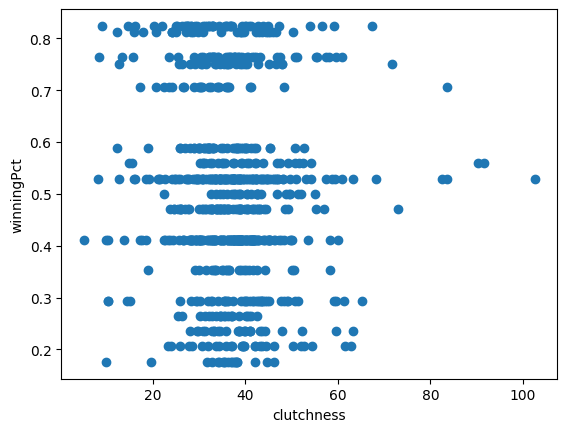

In [100]:
plt.scatter(individual_tackling['clutchness'], individual_tackling['winningPct'])
plt.xlabel('clutchness')
plt.ylabel('winningPct')

# Plotting Clutchness of Players vs Position

Text(0, 0.5, 'position')

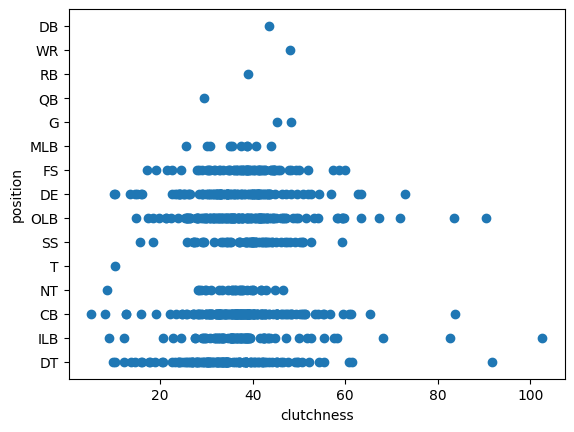

In [101]:
plt.scatter(individual_tackling['clutchness'], individual_tackling['position'])
plt.xlabel('clutchness')
plt.ylabel('position')

We can see here that there are some slight variations across position.  For example, free safeties (FS) tend to be a little less clutch than defensive ends (DE) in general